## Plots for experiments in finite regime

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
from src.policy import jaccard_distance
from src import utils
import pickle

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

### Load and process data

In [3]:
def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i].copy()
    else:
        raise Exception("Cannot merge")
    return old

In [4]:
filenames10 = [
"experiments/results_1581037908_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:1_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581038543_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:2_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036360_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:3_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037676_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:4_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581038242_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:5_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581038313_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:6_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581038394_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:7_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037545_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:8_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581038775_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:9_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037930_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:10_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle"
]

filenames100 = [
"experiments/results_1581036952_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:1_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037402_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:2_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036632_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:3_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036772_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:4_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036150_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:5_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036392_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:6_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037484_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:7_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037313_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:8_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037027_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:9_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036501_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:10_finite:True_max_iter:50_n:100_alpha:0.001_tag:cv_2feb6.pickle"
]

filenames1000 = [
"experiments/results_1581036767_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:1_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037079_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:2_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036534_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:3_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581038006_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:4_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037060_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:5_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037008_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:6_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037519_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:7_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036732_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:8_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581037078_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:9_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle",
"experiments/results_1581036966_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:10_finite:True_max_iter:50_n:1000_alpha:0.001_tag:cv_2feb6.pickle"
]

In [5]:
def load_results(filenames):
    cases, results = load_experiments(filenames[0])
    for filename in filenames[1::]:
        print("Loading %s" % filename)
        new_cases, new_results = load_experiments(filename)
        cases += new_cases
        for k in range(len(results)):
            results[k] = merge_runs(results[k], new_results[k])
    print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))
    return cases, results

In [6]:
def hamming_distance(A,B,p):
    a = np.zeros(p)
    b = np.zeros(p)
    a[list(A)] = 1
    b[list(B)] = 1
    return scipy.spatial.distance.hamming(a, b)

In [7]:
def generate_trajectories(results, cases):
    runs = len(results[0])
    N = len(results[0][0])
    P = len(results)

    results = [results[i] for i in [0,3,1,2,4,5,6,7]]

    no_ints = np.zeros((len(results), runs, N))
    #all_trajectories_jac = {}
    all_trajectories_ham = {}
    names = []
    for k, policy_runs in enumerate(results):
        name = policy_runs[0][0].policy
        print("Processing results for %s policy" % name, end="")
        names.append(name)
        #trajectories_jac = []
        trajectories_ham = []
        for i,run_results in enumerate(policy_runs):
            no_ints[k, i,:] = list(map(lambda result: len(result.interventions()), run_results))
            for j, result in enumerate(run_results):
                estimates = list(map(lambda step: step[0], result.history[0::])) + [result.estimate]
                #trajectory_jac = list(map(lambda estimate: jaccard_distance(cases[j].truth, estimate), estimates))
                trajectory_ham = list(map(lambda estimate: hamming_distance(cases[j].truth, estimate, cases[j].sem.p), estimates))
                #trajectories_jac.append(trajectory_jac)
                trajectories_ham.append(trajectory_ham)
        #all_trajectories_jac[name] = trajectories_jac
        all_trajectories_ham[name] = trajectories_ham
        print(" done")
    return all_trajectories_ham, N, P, runs, names, no_ints

In [8]:
cases10, results10 = load_results(filenames10)
cases100, results100 = load_results(filenames100)
cases1000, results1000 = load_results(filenames1000)
cases = cases10
all_trajectories_ham10, N, P, runs, names, no_ints10 = generate_trajectories(results10, cases10)
all_trajectories_ham100, _, _, _, _, no_ints100 = generate_trajectories(results100, cases100)
all_trajectories_ham1000, _, _, _, _, no_ints1000 = generate_trajectories(results1000, cases1000)

Loading experiments/results_1581038543_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:2_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle
Loading experiments/results_1581036360_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:3_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle
Loading experiments/results_1581037676_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state:4_finite:True_max_iter:50_n:10_alpha:0.001_tag:cv_2feb6.pickle
Loading experiments/results_1581038242_n_workers:-1_batch_size:20000_debug:False_avg_deg:3.0_G:30_runs:32_n_min:8_n_max:8_w_min:0.0_w_max:1.0_var_min:0.1_var_max:1.0_int_min:0.0_int_max:1.0_random_state

Processing results for markov policy done
Processing results for markov + e policy done
Processing results for markov + r policy done
Processing results for markov + e + r policy done


#### Set max. number of iterations to plot (eg. plot true positive recovery for the first 50 interventions)

In [9]:
max_iter = 50

**Summary of graphs used**

300 graphs in total


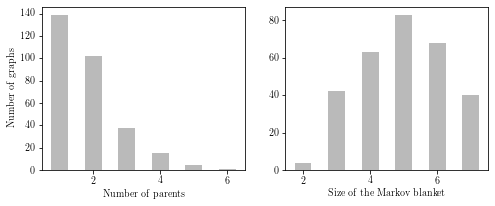

In [10]:
n_parents = np.zeros(N)
n_vars = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    n_parents[i] = len(case.truth)
    n_vars[i] = case.sem.p
    mb = utils.graph_info(case.target, case.sem.W)[3]
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(8,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(121), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(122), plot_hist(size_mb, "Size of the Markov blanket")
print("%d graphs in total" % N)

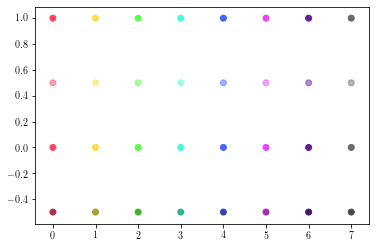

In [11]:
# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

In [12]:
# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

### Plots A: True Positive Recovery for `n=10`

In [13]:
mask = []
degree = 8
for i, case in enumerate(cases):
    parents, _, _, mb = utils.graph_info(case.target, case.sem.W)
    if len(parents) != len(mb) and case.sem.p == degree:
        mask.append(i)
mask = list(range(300))
len(mask)

300

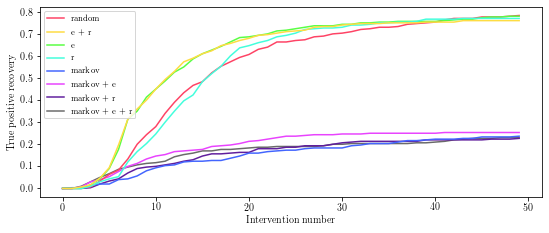

In [14]:
# Compute hamming distance
hm_dist = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(all_trajectories_ham10.items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist[i, j, 0:len(trajectory)] = trajectory
mean = np.mean(hm_dist[:, mask, :]==0, axis=1)
std = np.std(hm_dist[:, mask, :], axis=1) * 0.3
q25 = np.quantile(hm_dist[:, mask, :], 0.25, axis=1)
q75 = np.quantile(hm_dist[:, mask, :], 0.75, axis=1)
#mean = q75
# Plot
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)
plt.figure(figsize=(9,3.5))

# Plot trajectories
#plt.subplot(gs[0])
ax = plt.gca()
plot_iter = 50
x_axis = np.arange(0, plot_iter)
zorder = [1,4,2,3,-1,-2,-3,-4]
for i,name in enumerate(names):
    ax.plot(x_axis, mean[i,x_axis], label=name, linewidth=1.5, color=colors[i], zorder=zorder[i])    
plt.xlabel("Intervention number")
plt.ylabel("True positive recovery")
#axes.set_xticks(x_axis)
ax.legend(prop=fontP)

# Save figure
plt.savefig('figures/tpr_fin_10.pdf', bbox_inches='tight')

### Plots B: Number of interventions required

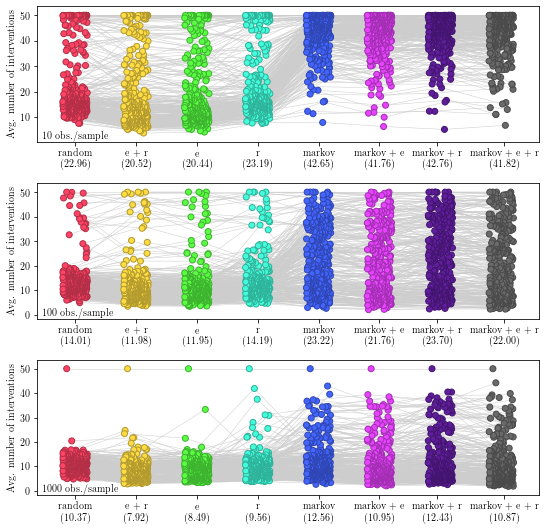

In [15]:
gs = gridspec.GridSpec(3, 1, wspace=0.15, hspace=0.3)
plt.figure(figsize=(9,9))

##############################
# n=10
plt.subplot(gs[0])
idx = mask
Ns = len(idx)
means = np.mean(no_ints10[:,:,idx], axis=1)

dev = 0.2
xaxis = np.tile(np.arange(P), (Ns, 1)) - np.outer(np.linspace(-dev, dev, Ns), np.ones(P))
ecolor = "#cdcdcd"
for i in range(Ns):
    plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5)
for i in range(Ns):
    plt.scatter(xaxis[i,:], means[:, i].T, marker="o", c=colors[0:P], zorder=1, edgecolors=colorsb)
plt.ylabel("Avg. number of interventions")
ax = plt.gca()
ax.set_xticks([0,1,2,3,4,5,5.95,7.05])
total_averages = means.mean(axis=1)
labels = []
for i, avg in enumerate(total_averages):
    labels.append(names[i] + "\n(%0.2f)" % avg)
ax.set_xticklabels(labels, ha="center", rotation=0)
ax.text(0.01,0.027,"10 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

##############################
# n=100
plt.subplot(gs[1])
idx = mask
Ns = len(idx)
means = np.mean(no_ints100[:,:,idx], axis=1)

dev = 0.2
xaxis = np.tile(np.arange(P), (Ns, 1)) - np.outer(np.linspace(-dev, dev, Ns), np.ones(P))
ecolor = "#cdcdcd"
for i in range(Ns):
    plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5)
for i in range(Ns):
    plt.scatter(xaxis[i,:], means[:, i].T, marker="o", c=colors[0:P], zorder=1, edgecolors=colorsb)
plt.ylabel("Avg. number of interventions")
ax = plt.gca()
ax.set_xticks([0,1,2,3,4,5,5.95,7.05])
total_averages = means.mean(axis=1)
labels = []
for i, avg in enumerate(total_averages):
    labels.append(names[i] + "\n(%0.2f)" % avg)
ax.set_xticklabels(labels, ha="center", rotation=0)
ax.text(0.01,0.027,"100 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

##############################
# n=1000
plt.subplot(gs[2])
idx = mask
Ns = len(idx)
means = np.mean(no_ints1000[:,:,idx], axis=1)

dev = 0.2
xaxis = np.tile(np.arange(P), (Ns, 1)) - np.outer(np.linspace(-dev, dev, Ns), np.ones(P))
ecolor = "#cdcdcd"
for i in range(Ns):
    plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5)
for i in range(Ns):
    plt.scatter(xaxis[i,:], means[:, i].T, marker="o", c=colors[0:P], zorder=1, edgecolors=colorsb)
plt.ylabel("Avg. number of interventions")
ax = plt.gca()
ax.set_xticks([0,1,2,3,4,5,5.95,7.05])
total_averages = means.mean(axis=1)
labels = []
for i, avg in enumerate(total_averages):
    labels.append(names[i] + "\n(%0.2f)" % avg)
ax.set_xticklabels(labels, ha="center", rotation=0)
ax.text(0.01,0.027,"1000 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

plt.savefig('figures/intervention_numbers_finite.pdf', bbox_inches='tight')

### Plots C: Comparing effects of sample size

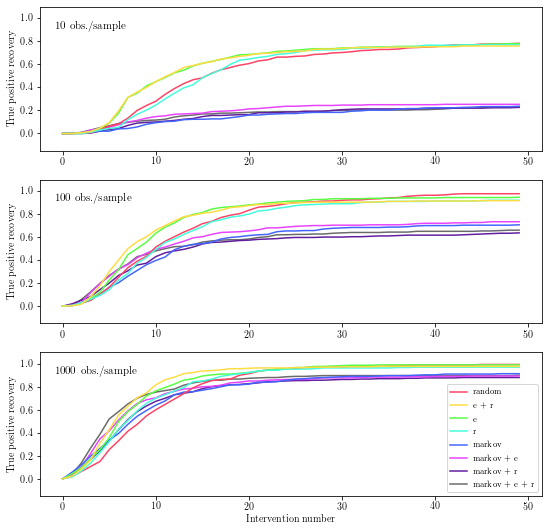

In [16]:
# Plot settings
gs = gridspec.GridSpec(3, 1, wspace=0.15, hspace=0.2)
plt.figure(figsize=(9,9))

plot_iter = 50
x_axis = np.arange(0, plot_iter)
ylim = [-0.15, 1.1]
mask = np.arange(N)

##############################
# Plot trajectories for n=10
hm_dist10 = np.zeros((P, N*runs, max_iter+1))
for i, trajectories in enumerate(all_trajectories_ham10.values()):
    for j, trajectory in enumerate(trajectories):
        hm_dist10[i, j, 0:len(trajectory)] = trajectory
mean10 = np.mean(hm_dist10[:, mask, :] ==0, axis=1)

plt.subplot(gs[0])
ax = plt.gca()
zorder = [1,4,2,3,-1,-2,-3,-4]
for i,name in enumerate(names):
    ax.plot(x_axis, mean10[i,x_axis], label=name, linewidth=1.5, color=colors[i], zorder=zorder[i])
plt.ylabel("True positive recovery")
#axes.set_xticks(x_axis)
#ax.legend(prop=fontP)
ax.text(0.03,0.85,"10 obs./sample", transform=ax.transAxes, fontsize=11, ha="left")
plt.ylim(ylim)
#ax.legend(prop=fontP)

##############################
# Plot trajectories for n=100
hm_dist100 = np.zeros((P, 1000*runs, max_iter+1))
for i, (name, trajectories) in enumerate(all_trajectories_ham100.items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist100[i, j, 0:len(trajectory)] = trajectory
mean100 = np.mean(hm_dist100[:, mask, :] == 0, axis=1)
plt.subplot(gs[1])
ax = plt.gca()
zorder = [1,4,2,3,-1,-2,-3,-4]
for i,name in enumerate(names):
    ax.plot(x_axis, mean100[i,x_axis], label=name, linewidth=1.5, color=colors[i], zorder=zorder[i])
plt.ylabel("True positive recovery")
#ax.set_yticklabels([])
#axes.set_xticks(x_axis)
ax.text(0.03,0.85,"100 obs./sample", transform=ax.transAxes, fontsize=11, ha="left")
plt.ylim(ylim)
#ax.legend(prop=fontP)

##############################
# Plot trajectories for n=1000
hm_dist1000 = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(all_trajectories_ham1000.items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist1000[i, j, 0:len(trajectory)] = trajectory
mean1000 = np.mean(hm_dist1000[:, mask, :] == 0, axis=1)

plt.subplot(gs[2])
ax = plt.gca()
zorder = [1,4,2,3,-1,-2,-3,-4]
for i,name in enumerate(names):
    ax.plot(x_axis, mean1000[i,x_axis], label=name, linewidth=1.5, color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
plt.ylabel("True positive recovery")
#axes.set_xticks(x_axis)
#ax.legend(prop=fontP)
ax.text(0.03,0.85,"1000 obs./sample", transform=ax.transAxes, fontsize=11, ha="left")
plt.ylim(ylim)
ax.legend(prop=fontP)
plt.savefig('figures/tpr_finite.pdf', bbox_inches='tight')